In [55]:
'''
Compare the taxi carpool and food delivery system
focus on waiting time and on-road time
Yi Ding
06/06/18
'''

import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [57]:
# Read in data
rideaustin = pd.read_csv(
    '/Users/eleme-yi/Documents/PhD/GitHub Pages/dymodi.github.io/Research/Beacon/data/rideshare/Rides_DataA.csv')
rideaustin['uid'] = rideaustin.index
# print(rideaustin.head())

elemedata = pd.read_excel(
    '/Users/eleme-yi/Documents/PhD/GitHub Pages/dymodi.github.io/Research/Beacon/data/rideshare/eleme_data.xlsx')
elemedata['uid'] = elemedata.index
# print(elemedata.head())

In [62]:
# Convert to datetime
# Warning: Very time-consuming
# Taxi data
df_datetime = pd.DataFrame()
df_datetime['uid'] = rideaustin.index
df_datetime['created_on'] = pd.to_datetime(rideaustin.created_date)
df_datetime['driver_reached_on'] = pd.to_datetime(rideaustin.driver_reached_on)
df_datetime['started_on'] = pd.to_datetime(rideaustin.started_on)
df_datetime['completed_on'] = pd.to_datetime(rideaustin.completed_on)
df_datetime['updated_on'] = pd.to_datetime(rideaustin.updated_date)
# print(df_datetime.head())

# Eleme data
df_datetime_eleme = pd.DataFrame()
df_datetime_eleme['uid'] = elemedata.index
df_datetime_eleme['accept_at'] = pd.to_datetime(elemedata.accept_at)
# df_datetime_eleme['arrive_rst_at'] = pd.to_datetime(elemedata.arrive_rst_at)
df_datetime_eleme['arrive_rst_at'] = pd.to_datetime(elemedata.arrive_rst_at_beacon)
# df_datetime_eleme['pickup_at'] = pd.to_datetime(elemedata.pickup_at)
df_datetime_eleme['pickup_at'] = pd.to_datetime(elemedata.leave_rst_at_beacon)
df_datetime_eleme['deliver_at'] = pd.to_datetime(elemedata.deliver_at)
# print(df_datetime_eleme.head())

In [63]:
# Check NaN in datetime dataframe
df_datetime.dropna(inplace=True)
if df_datetime.isnull().values.any():
    raise Exception('Still has NaN?')
if df_datetime_eleme.isnull().values.any():
    raise Exception('Still has NaN in eleme data?')

In [64]:
# Convert to timestamp
# Taxi data
df_timestamp = pd.DataFrame()
df_timestamp['uid'] = df_datetime.uid
df_timestamp['created_on'] = df_datetime.created_on.values.astype(np.int64) // 10 ** 9
df_timestamp['driver_reached_on'] = df_datetime.driver_reached_on.values.astype(np.int64) // 10 ** 9
df_timestamp['started_on'] = df_datetime.started_on.values.astype(np.int64) // 10 ** 9
df_timestamp['completed_on'] = df_datetime.completed_on.values.astype(np.int64) // 10 ** 9
df_timestamp['updated_on'] = df_datetime.updated_on.values.astype(np.int64) // 10 ** 9
print(df_timestamp.head())
# Eleme data
df_timestamp_eleme = pd.DataFrame()
df_timestamp_eleme['uid'] = df_datetime_eleme.uid
df_timestamp_eleme['accept_at'] = df_datetime_eleme.accept_at.values.astype(np.int64) // 10 ** 9
df_timestamp_eleme['arrive_rst_at'] = df_datetime_eleme.arrive_rst_at.values.astype(np.int64) // 10 ** 9
df_timestamp_eleme['pickup_at'] = df_datetime_eleme.pickup_at.values.astype(np.int64) // 10 ** 9
df_timestamp_eleme['deliver_at'] = df_datetime_eleme.deliver_at.values.astype(np.int64) // 10 ** 9
print(df_timestamp_eleme.head())

In [86]:
# Get time difference
# Taxi data
df_timediff = pd.DataFrame()
df_timediff['uid'] = df_timestamp.uid
df_timediff['wait_time'] = (df_timestamp.started_on-df_timestamp.driver_reached_on)
df_timediff['drive_time'] = (df_timestamp.completed_on-df_timestamp.started_on)
df_timediff['wait_ratio'] = df_timediff['wait_time']/df_timediff['drive_time']
print('TAXI data head')
print(df_timediff.head())
# Eleme data
df_timediff_eleme = pd.DataFrame()
df_timediff_eleme['uid'] = df_timestamp.uid
df_timediff_eleme['wait_time'] = (df_timestamp_eleme.pickup_at-df_timestamp_eleme.arrive_rst_at)
df_timediff_eleme['drive_time'] = (df_timestamp_eleme.deliver_at-df_timestamp_eleme.pickup_at)
df_timediff_eleme['wait_ratio'] = df_timediff_eleme['wait_time']/df_timediff_eleme['drive_time']
print('ELEME data head')
print(df_timediff_eleme.head())

TAXI data head
   uid  wait_time  drive_time  wait_ratio
0    0        278         523    0.531549
1    1         10          97    0.103093
2    2          1         115    0.008696
3    3        234         505    0.463366
4    4         10         102    0.098039
ELEME data head
   uid  wait_time  drive_time  wait_ratio
0    0        1.0      1086.0    0.000921
1    1       14.0       344.0    0.040698
2    2        0.0       234.0    0.000000
3    3       92.0      1725.0    0.053333
4    4       24.0      3755.0    0.006391


In [87]:
# Remove invalid values
# drive_time = 0 or wait_time = 0?
# Taxi
df_timediff = df_timediff[df_timediff.wait_time > 0]
df_timediff = df_timediff[df_timediff.drive_time > 0]
# EleMe
df_timediff_eleme = df_timediff_eleme[df_timediff_eleme.wait_time > 0]
df_timediff_eleme = df_timediff_eleme[df_timediff_eleme.drive_time > 0]

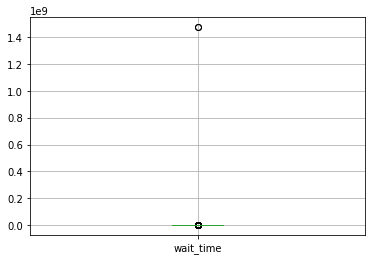

In [89]:
# Boxplot to have a first glance
print('Boxplot before removing outliers')
df_timediff.boxplot(column='wait_time')
plt.show()

TAXI data, length before removing outliers: 1287770
TAXI data, length after removing outliers: 1287770
TAXI data, 0.0  of total data removed.
ELEME data, length before removing outliers: 8374
ELEME data, length after removing outliers: 8374
ELEME data, 0.0  of total data removed.
Boxplot after removing outliers


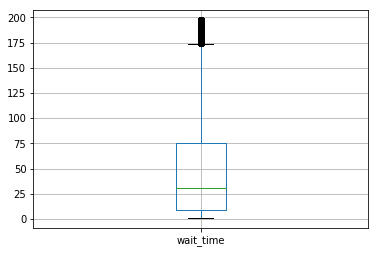

In [120]:
# Remove outliers (\mu \sigma method)
# Taxi
len_before_taxi = len(df_timediff.index)
print('TAXI data, length before removing outliers:', len_before_taxi)
wait_time_mean = df_timediff.wait_time.mean()
wait_time_std = df_timediff.wait_time.std()
drive_time_mean = df_timediff.drive_time.mean()
drive_time_std = df_timediff.drive_time.std()
wait_ratio_mean = df_timediff.wait_ratio.mean()
wait_ratio_std = df_timediff.wait_ratio.std()
df_timediff = df_timediff[df_timediff.wait_time > wait_time_mean - 3*wait_time_std]
df_timediff = df_timediff[df_timediff.wait_time < wait_time_mean + 3*wait_time_std]
df_timediff = df_timediff[df_timediff.drive_time > drive_time_mean - 3*drive_time_std]
df_timediff = df_timediff[df_timediff.drive_time < drive_time_mean + 3*drive_time_std]
# df_timediff = df_timediff[df_timediff.wait_ratio > wait_ratio_mean - 3*wait_ratio_std]
# df_timediff = df_timediff[df_timediff.wait_ratio < wait_ratio_mean + 3*wait_ratio_std]
print('TAXI data, length after removing outliers:', len(df_timediff.index))
print('TAXI data,', round((len_before_taxi-len(df_timediff.index))/len_before_taxi,3),' of total data removed.')
# ELE.ME
len_before_eleme = len(df_timediff_eleme.index)
print('ELEME data, length before removing outliers:', len(df_timediff_eleme.index))
wait_time_eleme_mean = df_timediff_eleme.wait_time.mean()
wait_time_eleme_std = df_timediff_eleme.wait_time.std()
drive_time_eleme_mean = df_timediff_eleme.drive_time.mean()
drive_time_eleme_std = df_timediff_eleme.drive_time.std()
wait_ratio_eleme_mean = df_timediff_eleme.wait_ratio.mean()
wait_ratio_eleme_std = df_timediff_eleme.wait_ratio.std()
df_timediff_eleme = df_timediff_eleme[df_timediff_eleme.wait_time > wait_time_eleme_mean - 3*wait_time_eleme_std]
df_timediff_eleme = df_timediff_eleme[df_timediff_eleme.wait_time < wait_time_eleme_mean + 3*wait_time_eleme_std]
df_timediff_eleme = df_timediff_eleme[df_timediff_eleme.drive_time > drive_time_eleme_mean - 3*drive_time_eleme_std]
df_timediff_eleme = df_timediff_eleme[df_timediff_eleme.drive_time < drive_time_eleme_mean + 3*drive_time_eleme_std]
# df_timediff_eleme = df_timediff_eleme[df_timediff_eleme.wait_ratio > wait_ratio_eleme_mean - 3*wait_ratio_eleme_std]
# df_timediff_eleme = df_timediff_eleme[df_timediff_eleme.wait_ratio < wait_ratio_eleme_mean + 3*wait_ratio_eleme_std]
print('ELEME data, length after removing outliers:', len(df_timediff_eleme.index))
print('ELEME data,', round((len_before_eleme-len(df_timediff_eleme.index))/len_before_eleme,3),
      ' of total data removed.')

# Boxplot to have a first glance
print('Boxplot after removing outliers')
df_timediff.boxplot(column='wait_time')
plt.show()

In [108]:
# Remove outliers (kmeans)
from sklearn.cluster import KMeans
wait_time_taxi_array = np.int64(df_timediff.drop(['uid','wait_ratio'], axis=1).values)
print(wait_time_taxi_array.dtype)
print(wait_time_taxi_array)

kmeans = KMeans(n_clusters=2).fit(wait_time_taxi_array)
labels = kmeans.labels_
print(np.sum(labels))

int64
[[ 10  97]
 [  1 115]
 [ 10 102]
 ..., 
 [ 44 478]
 [  4 588]
 [  5 168]]
440619


TAXI data summary
wait_time_mean: 48.9492587962
wait_time_std: 49.4211286204
drive_time_mean: 719.857662471
drive_time_std: 361.164383079
wait_ratio_mean: 0.176386718501
wait_ratio_std: 2.25182684248
ELEME data summary
wait_time_eleme_mean: 160.218652973
wait_time_eleme_std: 173.301896792
drive_time_eleme_mean: 861.058992118
drive_time_eleme_std: 496.25198088
wait_ratio_eleme_mean: 0.368561070749
wait_ratio_eleme_std: 4.74989385476
timediff_sort sample order by wait_ratio desc
             uid  wait_time  drive_time  wait_ratio
1267375  1267375        197           1       197.0
515864    515864        196           1       196.0
200635    200635        196           1       196.0
379883    379883        196           1       196.0
454891    454891        195           1       195.0
154047    154047        195           1       195.0
398563    398563        195           1       195.0
146094    146094        194           1       194.0
15261      15261        193           1       193.

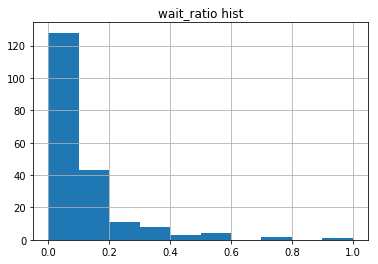

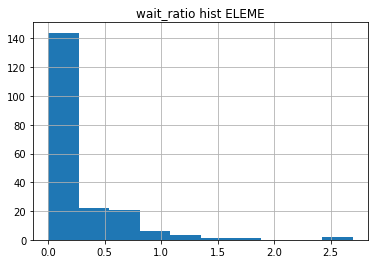

In [122]:
# # Show some special cases
# num_longer_than_1hour = 0
# for index, row in df_timediff.iterrows():
#     if row['wait_time'] > 3600:
# #         print('Wait more than 1 hour?')
# #         print('[row[uid]', row['uid'])
# #         raw_row = rideaustin.loc[rideaustin['uid'] == row['uid']]
# #         datatime_row = df_datetime.loc[df_datetime['uid'] == row['uid']]
# #         print('df_datetime')
# #         print(datatime_row)
# #         print('rideaustin')
# #         print(raw_row)
# #         print('-------------------------------------------')
#         num_longer_than_1hour = num_longer_than_1hour + 1        
# print(num_longer_than_1hour)






# Print result
# Taxi
print('TAXI data summary')
print('wait_time_mean:', wait_time_mean)
print('wait_time_std:', wait_time_std)
print('drive_time_mean:', drive_time_mean)
print('drive_time_std:', drive_time_std)
print('wait_ratio_mean:', wait_ratio_mean)
print('wait_ratio_std:', wait_ratio_std)
# ELEME
print('ELEME data summary')
print('wait_time_eleme_mean:', wait_time_eleme_mean)
print('wait_time_eleme_std:', wait_time_eleme_std)
print('drive_time_eleme_mean:', drive_time_eleme_mean)
print('drive_time_eleme_std:', drive_time_eleme_std)
print('wait_ratio_eleme_mean:', wait_ratio_eleme_mean)
print('wait_ratio_eleme_std:', wait_ratio_eleme_std)


# # Get some sample to have a insight
# # Taxi 
timediff_sample = df_timediff.sample(n=200)
# print(timediff_sample)
print('timediff_sort sample order by wait_ratio desc')
timediff_sort = df_timediff.sort_values(by='wait_ratio', ascending=False)
print(timediff_sort.head(10))
# ELEME
timediff_eleme_sample = df_timediff_eleme.sample(n=200)
print('timediff_eleme_sort sample order by wait_ratio desc ELEME')
timediff_eleme_sort = df_timediff_eleme.sort_values(by='wait_ratio', ascending=False)
print(timediff_eleme_sort.head(10))
# 为什么wait_ratio的mean和std是inf和nan？

# # Hist of wait time
# Taix
timediff_sample.hist('wait_ratio', bins=10)
plt.title('wait_ratio hist')
plt.show()
# ELEME
timediff_eleme_sample.hist('wait_ratio', bins=10)
plt.title('wait_ratio hist ELEME')
plt.show()